In [1]:
#########################
##  agn_xgboost        ##
##  Yu-Yen Chang       ##
##  2019.08.25         ##
#########################

import numpy as np
import os.path
from astropy.io import fits, ascii
from astropy.table import Table, Column, MaskedColumn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from xgboost import DMatrix
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import matshow

In [2]:
class AGN:

	kind = 'AGN'

	def __init__(self, name):
		self.name = name    # instance variable unique to each instance

	def ml_xgb(self, agnf0, mag00, fn):

		num = 1000         # num_round for training iterations
		## ========== XGBoost model ==========

		## split data into X and Y
		X = mag00
		Y = agnf0

		## split data into train and test sets
		self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, test_size=0.33, random_state=4)

		## imbalance class (Over-sampling )
		i_agn = np.where(self.y_train == 1) 
		i_ran = np.random.choice(i_agn[0], self.y_train.size)
		self.y_train = np.append(self.y_train,self.y_train[i_ran])
		self.X_train = np.concatenate((self.X_train,self.X_train[i_ran,:]))

		## define parameters
		dtrain = DMatrix(self.X_train, label=self.y_train, feature_names=fn)
		dtest = DMatrix(self.X_test, label=self.y_test, feature_names=fn)
		param = {
		    'max_depth': 5,                 # the maximum depth of each tree
		    'eta': 0.3,                     # the training step for each iteration
		    'silent': 1,                    # logging mode - quiet
		    'objective': 'multi:softprob',  # error evaluation for multiclass training
		    'num_class': 2}                 # the number of classes that exist in this datset
		num_round = num                     # the number of training iterations
		self.bst = xgb.train(param, dtrain, num_round)

		## predict Y value vs real Y test value
		self.Y_predict = self.bst.predict(dtest)
		self.y_predict = np.argmax(self.Y_predict ,axis=1)

		## ROC curve
		self.fpr = dict()
		self.tpr = dict()
		self.roc_auc = dict()
		for i in range(2):
		    self.fpr[i], self.tpr[i], _ = roc_curve(self.y_test, self.Y_predict[:,1])
		    self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

		## Precision Recall curve
		self.average_precision = average_precision_score(self.y_test,  self.Y_predict[:,1])
		self.precision, self.recall, _ = precision_recall_curve(self.y_test, self.Y_predict[:,1])
	    
	    ## Ouputs
		self.acc = '{:02.5f}'.format(metrics.accuracy_score(self.y_test, self.y_predict))
		self.p = '{:02.5f}'.format(metrics.precision_score(self.y_test, self.y_predict, average='macro'))
		self.r = '{:02.5f}'.format(metrics.recall_score(self.y_test, self.y_predict, average='macro'))
		self.f1 = '{:02.5f}'.format(metrics.f1_score(self.y_test, self.y_predict, average='macro'))
		self.roc = '{:02.5f}'.format(self.roc_auc[1])
		self.ap = '{:02.5f}'.format(self.average_precision)

		return [self.acc, self.p, self.r, self.f1, self.roc, self.ap]

In [3]:
## read fits file & data
hdul = fits.open('_agn_sel.fits')
data = hdul[1].data
header = hdul[1].header
ID = data['NUMBER']
gflux = data['g_cmodel_flux']
rflux = data['r_cmodel_flux']
iflux = data['i_cmodel_flux']
zflux = data['z_cmodel_flux']
yflux = data['y_cmodel_flux']
gflux_e = data['g_cmodel_fluxsigma']
rflux_e = data['r_cmodel_fluxsigma']
iflux_e = data['i_cmodel_fluxsigma']
zflux_e = data['z_cmodel_fluxsigma']
yflux_e = data['y_cmodel_fluxsigma']
redshift = data['photoz_best']
w1mag = data['w1mpro']
w2mag = data['w2mpro']
w1mag_e = data['w1sigmpro']
w2mag_e = data['w2sigmpro']

## choose data sets
##------HSC only------
#mag00 = np.column_stack((gflux, rflux, iflux, zflux, yflux, gflux_e, rflux_e, iflux_e, zflux_e, yflux_e, redshift))
#fn = ['g', 'r', 'i', 'z', 'y', 'g_e', 'r_e', 'i_e', 'z_e', 'y_e', 'redshift']
##------HSC+W12------
mag00 = np.column_stack((gflux, rflux, iflux, zflux, yflux, gflux_e, rflux_e, iflux_e, zflux_e, yflux_e, redshift, 
                         w1mag, w2mag, w1mag_e, w2mag_e))
fn = ['g', 'r', 'i', 'z', 'y', 'g_e', 'r_e', 'i_e', 'z_e', 'y_e', 'redshift', 'w1', 'w2', 'w1_e', 'w2_e']

print(ascii.read("_agn_sel.cat") )
mag00.shape

 NUMBER agn_x agn_ir agn_r ... w1mpro w1sigmpro w2mpro w2sigmpro
------- ----- ------ ----- ... ------ --------- ------ ---------
 261096     0      0     0 ... 15.558     0.045 15.371     0.103
 265378     0      0     0 ... 16.874     0.115 16.497     0.293
 269798     0      0     0 ... 15.034     0.036 14.561     0.059
 270407     0      0     0 ... 16.074     0.062 15.833     0.165
 270425     0      0     0 ... 16.303      0.08 16.126     0.219
 270519     0      0     0 ... 16.388     0.077 16.375     0.257
 270628     0      0     0 ... 16.074     0.062 15.833     0.165
 270653     0      0     0 ... 16.898     0.122 16.276     0.248
 270830     0      0     0 ... 16.667     0.087 16.442     0.259
 270945     0      0     0 ... 14.613     0.031 14.739     0.065
    ...   ...    ...   ... ...    ...       ...    ...       ...
1162372     0      0     0 ... 15.913     0.057 15.608     0.128
1162386     0      0     0 ... 14.128     0.027 14.261      0.05
1162458     0      0     

(8223, 15)

In [4]:
#---XAGN---
indtf = np.where(data['agn_x'] == 1)
agnf0 = np.zeros(len(redshift))
agnf0[indtf] = 1
agn1 = AGN('XAGN')
output_agn1 = agn1.ml_xgb(agnf0, mag00, fn)

#---IRAGN---
indtf = np.where(data['agn_ir'] == 1)
agnf0 = np.zeros(len(redshift))
agnf0[indtf] = 1
agn2 = AGN('IRAGN')
output_agn2 = agn1.ml_xgb(agnf0, mag00, fn)

#---RAGN---
indtf = np.where(data['agn_r'] == 1)
agnf0 = np.zeros(len(redshift))
agnf0[indtf] = 1
agn3 = AGN('RAGN')
output_agn3 = agn1.ml_xgb(agnf0, mag00, fn)

output = Table(np.split(np.reshape([output_agn1, output_agn2, output_agn3], (18, 1)), 6), 
               names=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUROC', 'AP'])
print(output)

Accuracy [1] Precision [1] Recall [1] F1 Score [1] AUROC [1]  AP [1]
------------ ------------- ---------- ------------ --------- -------
     0.97568       0.64275    0.98416      0.66522   0.88873 0.61535
     0.75919       0.82593    0.78298      0.81953   0.67380 0.79555
     0.60067       0.29981    0.61807      0.27844   0.59288 0.29487


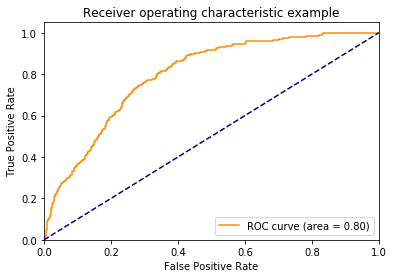

In [5]:
plt.plot(agn1.fpr[1], agn1.tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % agn1.roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

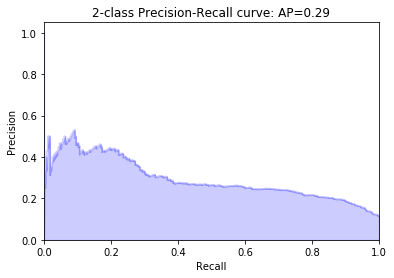

In [6]:
plt.step(agn1.recall, agn1.precision, color='b', alpha=0.2, where='post')
plt.fill_between(agn1.recall, agn1.precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(agn1.average_precision))
plt.show()

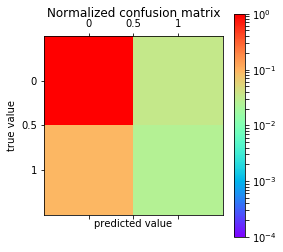

In [7]:
mt = metrics.confusion_matrix(agn1.y_test, agn1.y_predict)
m = mt/np.max(mt)
plt.matshow(m, cmap=plt.get_cmap('rainbow'), norm=colors.LogNorm(vmin=1e-4, vmax=1))
plt.colorbar()
plt.title('Normalized confusion matrix', pad=10)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.xticks([0, 0.5, 1], ['0', '0.5', '1'])
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'])
plt.show()

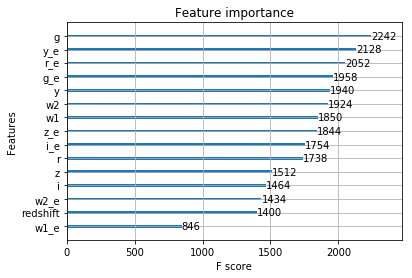

In [8]:
xgb.plot_importance(agn1.bst)
plt.show()